In [14]:
# Celda de configuración
# Elegir qué métodos ejecutar
CORRER_ECUACIONES_NORMALES = True
CORRER_SVD = True
CORRER_QR = True

ALEATORIZAR_MUESTRAS = True   # mezclar antes de recortar columnas

# Semilla para reproducibilidad en el recorte
# Sirve para que, si ALEATORIZAR_MUESTRAS=True, la selección aleatoria de columnas sea siempre la misma (resultados reproducibles).
SEMILLA_REDUCCION = 287238

HISTORICO_RESULTADOS = []


In [15]:
from pathlib import Path
import time
import numpy as np
import alc
import matplotlib.pyplot as plt

# Directorio del dataset (relativo al repo)
RUTA_DATASET = Path('template-alumnos/dataset/cats_and_dogs')
assert RUTA_DATASET.exists(), f'No se encontró el dataset en {RUTA_DATASET.resolve()}'


In [16]:
# Recarga de módulos de la librería de la cátedra
import importlib


# Luego recargar el paquete para refrescar los símbolos
moduloALC = importlib.reload(alc)

# Reasignar alias usado en el notebook
alc = moduloALC

In [17]:
# Carga de datos usando cargarDataset del main 
X_train, Y_train, X_val, Y_val = alc.cargarDataset(str(RUTA_DATASET))

# Evaluacion y Benchmarking

A continuación presentamos el procedimiento que seguimos para la validacion de los modelos utilizados.

Primero se calcula la matriz de pesos:

$$
W
$$

usando el set de entrenamiento $X_t$.

Luego se evalúa el modelo en el conjunto de validación:

$$
Y_{\text{pred}} = W X_v
$$

Finalmente, se compara $Y_{\text{pred}}$ con las etiquetas verdaderas del conjunto de validación:

$$
Y_v
$$

---

## Matriz de confusión

Para evaluar el desempeño del modelo, construimos una **matriz de confusión**.  
En el caso binario (por ejemplo, $gato$ vs. $perro$), la matriz tiene forma:

$
C =
\begin{pmatrix}
\text{TP} & \text{FN} \\
\text{FP} & \text{TN}
\end{pmatrix},
\
$

donde:

- **TP (True Positive):** predice clase 1 y es clase 1  
- **FN (False Negative):** predice clase 0 pero era clase 1  
- **FP (False Positive):** predice clase 1 pero era clase 0  
- **TN (True Negative):** predice clase 0 y es clase 0  

---

## Cálculo del accuracy

El accuracy se calcula como

\$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$

En nuestro caso, a partir de $Y_{pred}$ determinamos la clase escogida para cada imagen (tomando el índice del mayor valor en sus dos componentes) y la comparamos con $Y_v$ para ir llenando la matriz $ C $.

Una vez construida la matriz de confusión, el accuracy surge directamente de la fórmula anterior.

### Matriz de confusion con ecuaciones normales:

In [23]:
L = None  # opcional: si ya tenés L (Cholesky) calculada, pasala aquí

W = alc.pinvEcuacionesNormales(X_train, L, Y_train)  # obtengo W

Yv_pred = W @ X_val  # predicciones

# Separo por clases
pred = np.argmax(Yv_pred, axis=0)
true = np.argmax(Y_val, axis=0)

print("True labels:", true)
print("Pred labels:", pred)

accuracy = np.mean(pred == true)
print("Accuracy:", accuracy)


def confusion_matrix(true, pred, num_classes):
    M = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(true, pred):
        M[t, p] += 1
    return M

cm = confusion_matrix(true, pred, num_classes=2)
print("Confusion matrix:\n", cm)


KeyboardInterrupt: 

### Matriz de confusion con SVD:

In [ ]:
U, S, V = alc.svd_reducida(X_train)

W = alc.pinvSVD(U,S,V,Y_train)
    
Yv_pred = W @ X_val #predicciones

#Separo por clases

pred = np.argmax(Yv_pred, axis=0)
true = np.argmax(Y_val, axis=0)

print("True labels:", true)
print("Pred labels:", pred)

accuracy = np.mean(pred == true)
print("Accuracy:", accuracy)

cm = confusion_matrix(true, pred, num_classes=2)
print("Confusion matrix:\n", cm)

## Matriz de confusion con QR

### Gram-Schmidt:

In [ ]:

Q, R = alc.QR_con_GS_MatRectangular(alc.traspuesta(X_train))

W = alc.pinvGramSchmidt(Q, R, Y_train)

Yv_pred = W @ X_val #predicciones

#Separo por clases

pred = np.argmax(Yv_pred, axis=0)
true = np.argmax(Y_val, axis=0)

print("True labels:", true)
print("Pred labels:", pred)

accuracy = np.mean(pred == true)
print("Accuracy:", accuracy)

cm = confusion_matrix(true, pred, num_classes=2)
print("Confusion matrix:\n", cm)

### HouseHolder:

In [ ]:
Q, R = alc.QR_con_HH( alc.traspuesta(X_train) ) #obtengo Q y R con HouseHolder

W = alc.pinvHouseHolder(Q, R, Y_train) 

Yv_pred = W @ X_val #predicciones

#Separo por clases

pred = np.argmax(Yv_pred, axis=0)
true = np.argmax(Y_val, axis=0)

print("True labels:", true)
print("Pred labels:", pred)

accuracy = np.mean(pred == true)
print("Accuracy:", accuracy)

cm = confusion_matrix(true, pred, num_classes=2)
print("Confusion matrix:\n", cm)

# Tiempos de ejecucion y comparaciones entre metodos

A continuacion:
- Se carga los embeddings de `cats_and_dogs` y sus etiquetas (train/val)
- Se entrena un clasificador lineal `W` con los métodos:
  - Ecuaciones Normales (factorización de Cholesky)
  - Pseudo-inversa vía SVD
  - Descomposición QR
- Se compara tiempos de entrenamiento y accuracy en validación



### Carga y reducción del conjunto de entrenamiento

Anteriormente cargamos el dataset usando la función `cargarDataset` del módulo
principal. Esto nos devuelve cuatro matrices:

- `X_train ∈ ℝ^{n×p}`: matriz de embeddings de entrenamiento (cada **columna**
  es una imagen; cada **fila**, una coordenada del embedding).
- `Y_train ∈ ℝ^{m×p}`: matriz de etiquetas en formato one–hot (en este caso,
  dos filas: gato / perro).
- `X_val`, `Y_val`: análogas a las anteriores, pero para el conjunto de
  validación.

A continuación definimos una función auxiliar que, dado un par
`(X_a_reducir, Y_a_reducir)` y un valor `max_columnas_train`, permite limitar
la cantidad de ejemplos de entrenamiento:

- Si el número de columnas de `X_a_reducir` es mayor o igual que
  `max_columnas_train`, se construye un vector de índices de columnas y, si la
  bandera `ALEATORIZAR_MUESTRAS` está activada, estos índices se mezclan de
  forma pseudoaleatoria usando una semilla fija (`SEMILLA_REDUCCION`) para
  garantizar reproducibilidad.
- Luego se toman solamente las primeras `max_columnas_train` columnas, tanto de
  la matriz de embeddings como de la matriz de etiquetas, obteniendo un
  conjunto de entrenamiento reducido.
- Si el número de columnas original ya es menor que `max_columnas_train`, las
  matrices se dejan sin cambios.

Esta reducción controlada nos permite trabajar con distintos tamaños de
conjunto de entrenamiento (por ejemplo 50, 100, 250, 500 columnas, etc.) para
estudiar el comportamiento de los métodos de Cholesky, SVD y QR sin necesidad
de usar siempre el dataset completo.


In [24]:
def reducir_tamanio(X_a_reducir, Y_a_reducir, max_columnas_train, semilla_reducir=SEMILLA_REDUCCION):
    if X_a_reducir.shape[1] >= max_columnas_train:
        indices = np.arange(X_a_reducir.shape[1])
        if ALEATORIZAR_MUESTRAS:
            rng = np.random.default_rng(semilla_reducir)
            rng.shuffle(indices)
        indices = indices[:max_columnas_train]
        X_train_reducido = X_train[:, indices]
        Y_train_reducido = Y_train[:, indices]
        return X_train_reducido, Y_train_reducido
    
    return X_a_reducir, Y_a_reducir


### Cálculo de exactitud y rutina de evaluación de los métodos

En esta sección definimos, primero, una función auxiliar para medir la
**exactitud de clasificación** a partir de los puntajes, y luego una función
general que ejecuta cada método (Ecuaciones Normales, SVD y QR) y guarda sus
resultados.

La función `exactitud_desde_puntajes(W, X, Y_verdadera)` recibe:

- `W`: la matriz de pesos aprendida por algún método (Cholesky, SVD o QR),
- `X`: la matriz de datos sobre la que queremos evaluar (train o validación),
- `Y_verdadera`: la matriz de etiquetas verdaderas en formato one–hot.

Primero calcula los **puntajes** como `W @ X`, es decir, cada columna del
resultado son los puntajes para cada clase de un ejemplo. Luego:

- Usa `np.argmax(..., axis=0)` sobre los puntajes para obtener la predicción
  de clase de cada ejemplo (`y_pred`).
- Usa `np.argmax(..., axis=0)` sobre `Y_verdadera` para recuperar la clase
  verdadera de cada ejemplo (`y_true`).
- Finalmente, computa la **exactitud** como el promedio de aciertos
  `mean(y_pred == y_true)` y la devuelve como `float`.

La función `obtener_resultados(X_reducido, Y_reducido, X_test = X_val, Y_test = Y_val)`
es la rutina principal de evaluación: dada una matriz de entrenamiento (posiblemente
reducida) y su conjunto de test/validación, ejecuta los métodos activados por las
banderas `CORRER_ECUACIONES_NORMALES`, `CORRER_SVD` y `CORRER_QR`. Para cada método:

- Mide el **tiempo de entrenamiento** usando `time.perf_counter()`.
- Imprime un mensaje indicando el método y el tamaño de `X_reducido` que se está
  usando.
- Calcula la matriz de pesos `W` correspondiente:
  - `pinvEcuacionesNormales` para Ecuaciones Normales (Cholesky),
  - `svd_reducida` + `pinvSVD` para SVD,
  - `QR_con_GS_MatRectangular`/`QR_con_HH` + `pinvGramSchmidt`/`pinvHouseHolder`
    para los casos de QR.
- Evalúa la **exactitud en entrenamiento** (`exactitud_train`) usando
  `exactitud_desde_puntajes(W, X_reducido, Y_reducido)`.
- Evalúa la **exactitud en validación/test** (`exactitud_val`) usando
  `exactitud_desde_puntajes(W, X_test, Y_test)`.

Toda esta información se guarda en un diccionario `resultados`, con una entrada
por método (por ejemplo `ecuaciones_normales`, `SVD`, `QR_GS`, `QR_HH`), donde
cada entrada contiene:

- el tiempo de entrenamiento en segundos,
- la exactitud en entrenamiento,
- la exactitud en validación.

La función devuelve este diccionario, que luego se usa para comparar
sistemáticamente tiempos y performances de los distintos algoritmos en los
experimentos del TP.


In [25]:
def exactitud_desde_puntajes(W: np.ndarray, X: np.ndarray, Y_verdadera: np.ndarray) -> float:
    puntajes = alc.productoMatricial(W, X)
    y_pred = np.argmax(puntajes, axis=0)
    y_true = np.argmax(Y_verdadera, axis=0)
    return float(np.mean(y_pred == y_true))


def obtener_resultados(X_reducido, Y_reducido, X_test = X_val, Y_test = Y_val):
    resultados = {}

    # Ecuaciones Normales (Cholesky)
    if CORRER_ECUACIONES_NORMALES:
        inicio = time.perf_counter()
        print("Comenzando ecuaciones normales para tamaño ", X_reducido.shape[1], " hora: ", time.strftime("%H:%M:%S"))
        W_normal = alc.pinvEcuacionesNormales(X_reducido, None, Y_reducido)
        Tiempo_entrenamiento_normal = time.perf_counter() - inicio

        acc_train_normal = exactitud_desde_puntajes(W_normal, X_reducido, Y_reducido)
        acc_val_normal = exactitud_desde_puntajes(W_normal, X_test, Y_test)

        resultados['ecuaciones_normales'] = {
            'tiempo_entrenamiento_s': Tiempo_entrenamiento_normal,
            'exactitud_train': acc_train_normal,
            'exactitud_val': acc_val_normal,
        }

    # SVD
    if CORRER_SVD:
        inicio = time.perf_counter()
        print("Comenzando SVD para tamaño ", X_reducido.shape[1], " hora: ", time.strftime("%H:%M:%S"))
        U, S, V = alc.svd_reducida(X_reducido)
        W_svd = alc.pinvSVD(U, S, V, Y_reducido)
        Tiempo_entrenamiento_svd = time.perf_counter() - inicio

        acc_train_svd = exactitud_desde_puntajes(W_svd, X_reducido, Y_reducido)
        acc_val_svd = exactitud_desde_puntajes(W_svd, X_test, Y_test)

        resultados['SVD'] = {
            'tiempo_entrenamiento_s': Tiempo_entrenamiento_svd,
            'exactitud_train': acc_train_svd,
            'exactitud_val': acc_val_svd,
        }

    # QR
    if CORRER_QR:
        # Gram-Schmidt
        inicio = time.perf_counter()
        print("Comenzando Gram-Schmidt para tamaño ", X_reducido.shape[1], " hora: ", time.strftime("%H:%M:%S"))
        Q_gs, R_gs = alc.QR_con_GS_MatRectangular(alc.traspuesta(X_reducido))
        W_qr_gs = alc.pinvGramSchmidt(Q_gs, R_gs, Y_reducido)
        Tiempo_entrenamiento_qr_gs = time.perf_counter() - inicio
        acc_train_qr_gs = exactitud_desde_puntajes(W_qr_gs, X_reducido, Y_reducido)
        acc_val_qr_gs = exactitud_desde_puntajes(W_qr_gs, X_test, Y_test)
        resultados['QR_GS'] = {
            'tiempo_entrenamiento_s': Tiempo_entrenamiento_qr_gs,
            'exactitud_train': acc_train_qr_gs,
            'exactitud_val': acc_val_qr_gs,
        }

        # Householder
        inicio = time.perf_counter()
        print("Comenzando Householder para tamaño ", X_reducido.shape[1], " hora: ", time.strftime("%H:%M:%S"))
        Q_hh, R_hh = alc.QR_con_HH(alc.traspuesta(X_reducido))
        W_qr_hh = alc.pinvHouseHolder(Q_hh, R_hh, Y_reducido)
        Tiempo_entrenamiento_qr_hh = time.perf_counter() - inicio
        acc_train_qr_hh = exactitud_desde_puntajes(W_qr_hh, X_reducido, Y_reducido)
        acc_val_qr_hh = exactitud_desde_puntajes(W_qr_hh, X_test, Y_test)
        resultados['QR_HH'] = {
            'tiempo_entrenamiento_s': Tiempo_entrenamiento_qr_hh,
            'exactitud_train': acc_train_qr_hh,
            'exactitud_val': acc_val_qr_hh,
        }

    # Registrar en variable global
    entry = {'tam': int(X_reducido.shape[1]), 'resultados': resultados}
    HISTORICO_RESULTADOS.append(entry)


    return resultados


### Ejecución de experimentos y visualización de resultados

En esta sección definimos una función auxiliar para **mostrar y graficar** los
resultados obtenidos por cada método, y luego la utilizamos sobre distintos
tamaños del conjunto de entrenamiento.

La función `mostrar_resultados(resultados)` recibe el diccionario devuelto por
`obtener_resultados` y realiza dos tareas:

1. **Salida por consola**  
   Recorre las claves del diccionario (cada una corresponde a un método:
   `ecuaciones_normales`, `SVD`, `QR_GS`, `QR_HH`, etc.) e imprime:
   - el tiempo de entrenamiento en segundos,
   - la exactitud en entrenamiento,
   - la exactitud en validación.

2. **Gráficos de barras comparativos**  
   Construye dos listas:
   - `tiempos`: tiempos de entrenamiento por método,
   - `exactitudes`: exactitud en validación por método.

   Luego genera una figura con dos subgráficos:
   - a la izquierda, un gráfico de barras del **tiempo de entrenamiento** por
     método;
   - a la derecha, un gráfico de barras de la **exactitud en validación** por
     método (acotada entre 0 y 1).  
   Esto permite comparar visualmente, para un tamaño fijo de matriz,
   el compromiso entre costo computacional y performance de cada algoritmo.

A continuación se construyen subconjuntos del conjunto de entrenamiento
aplicando `reducir_tamanio` con distintos números máximos de columnas:
`50`, `100`, `250`, `500` y `2000`. Cada llamada devuelve matrices
`X_k`, `Y_k` que contienen solo `k` ejemplos.  

La variable `CORRER_QR` se pone en `False` en esta celda, ya que QR solo es
aplicable en el caso \(n < p\); para matrices reducidas de tamaño 50, 100, 250
y 500 se tiene típicamente \(n > p\), por lo que aquí se evalúan únicamente
Ecuaciones Normales (Cholesky) y SVD.

Finalmente, para cada tamaño (`50`, `100`, `250`, `500`) se imprime un encabezado
indicando el tamaño de la matriz reducida y se llama a:

```python
mostrar_resultados(obtener_resultados(X_k, Y_k))

lo que produce tanto la tabla textual de tiempos y exactitudes como los gráficos de barras correspondientes para ese tamaño del conjunto de entrenamiento.

Resultados para matriz reducida a 50 columnas:
Comenzando ecuaciones normales para tamaño  50  hora:  12:05:44
Comenzando SVD para tamaño  50  hora:  12:05:44
Resultados:

Método: ecuaciones_normales
  tiempo entrenamiento (s): 0.5813
  exactitud train: 1.0000
  exactitud val  : 0.5410

Método: SVD
  tiempo entrenamiento (s): 1.0368
  exactitud train: 1.0000
  exactitud val  : 0.5410


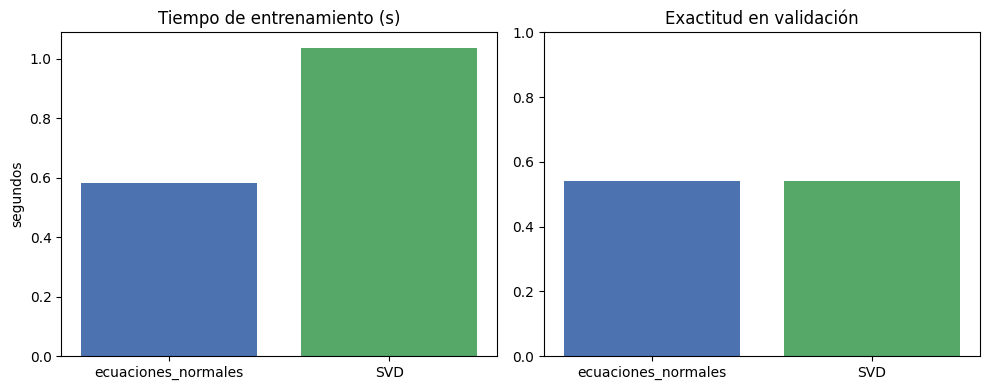

Resultados para matriz reducida a 100 columnas:
Comenzando ecuaciones normales para tamaño  100  hora:  12:05:46
Comenzando SVD para tamaño  100  hora:  12:05:48
Resultados:

Método: ecuaciones_normales
  tiempo entrenamiento (s): 2.2712
  exactitud train: 1.0000
  exactitud val  : 0.5520

Método: SVD
  tiempo entrenamiento (s): 8.4751
  exactitud train: 1.0000
  exactitud val  : 0.5520


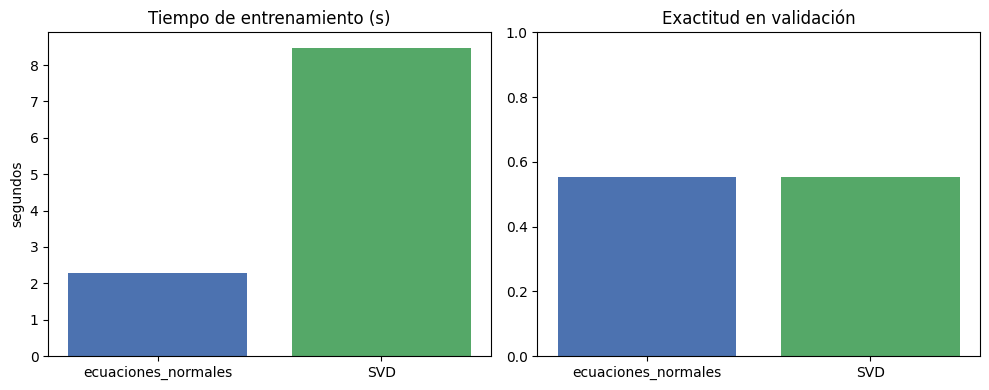

Resultados para matriz reducida a 250 columnas:
Comenzando ecuaciones normales para tamaño  250  hora:  12:05:56
Comenzando SVD para tamaño  250  hora:  12:06:15
Resultados:

Método: ecuaciones_normales
  tiempo entrenamiento (s): 18.2851
  exactitud train: 1.0000
  exactitud val  : 0.5800

Método: SVD
  tiempo entrenamiento (s): 202.7864
  exactitud train: 1.0000
  exactitud val  : 0.5800


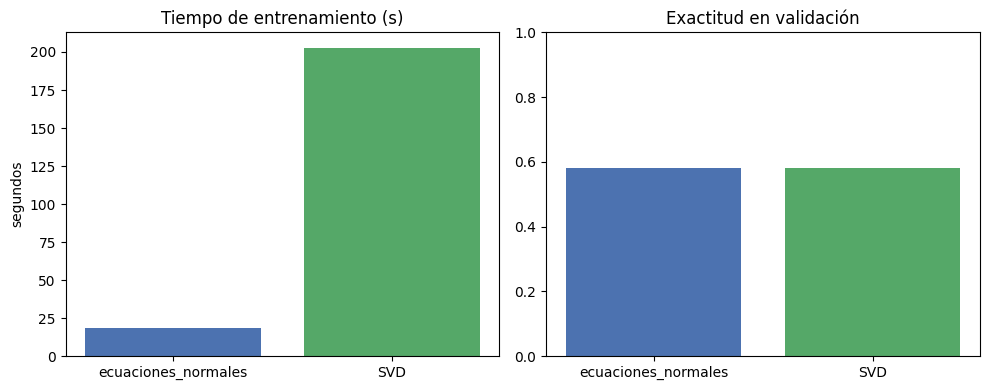

Resultados para matriz reducida a 500 columnas:
Comenzando ecuaciones normales para tamaño  500  hora:  12:09:38
Comenzando SVD para tamaño  500  hora:  12:11:26
Resultados:

Método: ecuaciones_normales
  tiempo entrenamiento (s): 108.2544
  exactitud train: 1.0000
  exactitud val  : 0.6390

Método: SVD
  tiempo entrenamiento (s): 2123.5187
  exactitud train: 1.0000
  exactitud val  : 0.6390


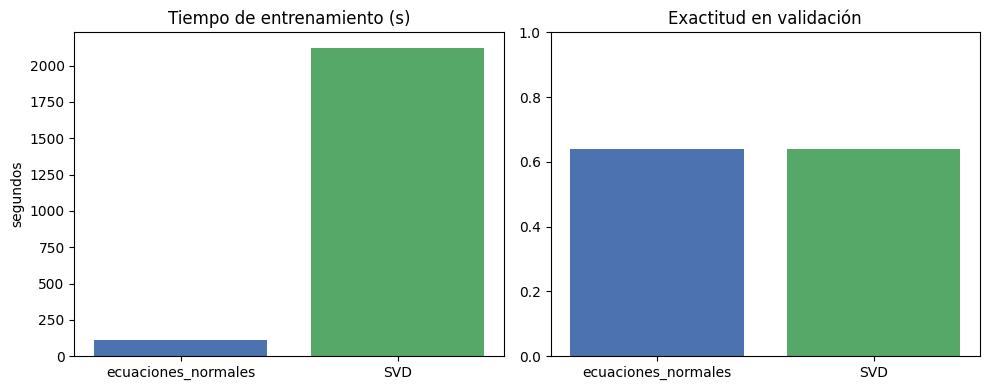

In [26]:
# Mostrar resultados y gráficos de comparación
def mostrar_resultados(resultados):
    print('Resultados:')
    for metodo, valores in resultados.items():
        print(f"\nMétodo: {metodo}")
        print(f"  tiempo entrenamiento (s): {valores['tiempo_entrenamiento_s']:.4f}")
        print(f"  exactitud train: {valores['exactitud_train']:.4f}")
        print(f"  exactitud val  : {valores['exactitud_val']:.4f}")

    metodos = list(resultados.keys())
    tiempos = [resultados[m]['tiempo_entrenamiento_s'] for m in metodos]
    exactitudes = [resultados[m]['exactitud_val'] for m in metodos]

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.bar(metodos, tiempos, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#937860', '#DA8BC3', '#7C4D7D', '#C496B5', '#A4A4A4', '#B56576'])
    plt.title('Tiempo de entrenamiento (s)')
    plt.ylabel('segundos')

    plt.subplot(1,2,2)
    plt.bar(metodos, exactitudes, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#937860', '#DA8BC3', '#7C4D7D', '#C496B5', '#A4A4A4', '#B56576'])
    plt.title('Exactitud en validación')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()
    
    
X_50, Y_50 = reducir_tamanio(X_train, Y_train, 50, 32432)
X_100, Y_100 = reducir_tamanio(X_train, Y_train, 100, 92731)
X_250, Y_250 = reducir_tamanio(X_train, Y_train, 250, 12353)
X_500, Y_500 = reducir_tamanio(X_train, Y_train, 500, 65434)
X_2000, Y_2000 = reducir_tamanio(X_train, Y_train, 2000, 2321124)

CORRER_QR = False # necesita n < p

print("Resultados para matriz reducida a 50 columnas:")
mostrar_resultados(obtener_resultados(X_50, Y_50))

print("Resultados para matriz reducida a 100 columnas:")
mostrar_resultados(obtener_resultados(X_100, Y_100))

print("Resultados para matriz reducida a 250 columnas:")
mostrar_resultados(obtener_resultados(X_250, Y_250))

print("Resultados para matriz reducida a 500 columnas:")
mostrar_resultados(obtener_resultados(X_500, Y_500))


### Experimento final con 2000 columnas: comparación con QR

En esta última celda realizamos el experimento sobre la matriz de entrenamiento
reducida a `2000` columnas (`X_2000`, `Y_2000`), que es el único caso en el que
se cumple aproximadamente `n < p` (menos filas que columnas). Este es
precisamente el régimen para el cual los métodos basados en descomposición QR
resultan más naturales, ya que permiten evitar trabajar explícitamente con las
ecuaciones normales sobre `Xᵀ X`.

Primero configuramos las banderas de ejecución:

- `CORRER_QR = True`: habilitamos la evaluación de los métodos basados en QR
  (Gram–Schmidt modificado y Householder).
- `CORRER_SVD = False`: deshabilitamos SVD para este tamaño, ya que su costo
  computacional es muy alto; en nuestro contexto, intentar correr SVD sobre la
  matriz correspondiente llevó más de 24 horas sin finalizar, por lo que no es
  práctico incluirlo en los experimentos.

Luego se imprime un encabezado indicando que estamos trabajando con la matriz
reducida a `2000` columnas y se llama a:

`mostrar_resultados(obtener_resultados(X_2000, Y_2000))`

Esta llamada utiliza la rutina general `obtener_resultados` (que ahora ejecuta
Ecuaciones Normales y QR, pero no SVD) y la función `mostrar_resultados`, que
imprime tiempos y exactitudes y genera los gráficos comparativos. De este modo,
podemos analizar específicamente el comportamiento de Cholesky frente a los
métodos QR en el caso de mayor tamaño considerado, y en el régimen en el que el
algoritmo 3 del enunciado está pensado para trabajar.


Resultados para matriz reducida a 2000 columnas:
Comenzando ecuaciones normales para tamaño  2000  hora:  13:49:44
Comenzando Gram-Schmidt para tamaño  2000  hora:  15:04:36
Comenzando Householder para tamaño  2000  hora:  15:13:22
Resultados:

Método: ecuaciones_normales
  tiempo entrenamiento (s): 4492.8326
  exactitud train: 0.9905
  exactitud val  : 0.6840

Método: QR_GS
  tiempo entrenamiento (s): 525.1240
  exactitud train: 0.9905
  exactitud val  : 0.6840

Método: QR_HH
  tiempo entrenamiento (s): 1151.1973
  exactitud train: 0.9905
  exactitud val  : 0.6840


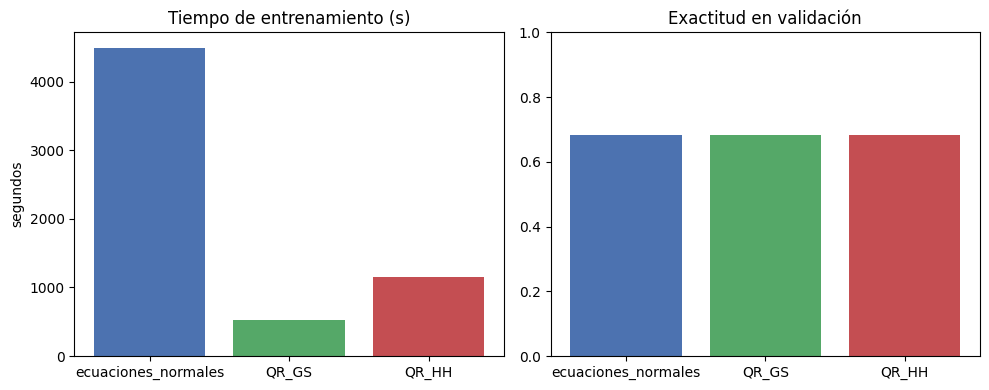

In [ ]:
CORRER_QR = True
CORRER_SVD = False # Tarda mas de 24hs en correr

print("Resultados para matriz reducida a 2000 columnas:")
mostrar_resultados(obtener_resultados(X_2000, Y_2000))

In [ ]:
# Sería ideal graficar todo en un mismo plot (por ejemplo, con puntos, tomando el eje X como tamaño y el eje Y como tiempo). De esa forma se podría ver la tendencia. Lo mismo vale para el accuracy. 

### Conclusiones

En este trabajo logramos comparar la eficacia de los tres métodos: ecuaciones normales basadas en Cholesky,
descomposición en valores singulares (SVD) y descomposición QR, con el objetivo de calcular los pesos en
la matriz $W$. Para ello, en cada uno realizamos el cálculo de $X_t^{+}$, la pseudoinversa de la matriz de
embeddings $X_t$.

Disponer de la matriz de pesos $W$ nos permite resolver el problema de optimización
formulado como $ \min_{W} \| Y - W X \|^{2} $ . Obtener $W$ equivale a encontrar la matriz
que mejor aproxima a $Y$ a partir de los datos de entrada representados por $X$, minimizando el error
cuadrático entre la predicción $W X$ y los valores reales $Y$. De esta manera, el cálculo de $W$ provee
la solución óptima en el sentido de mínimos cuadrados, asegurando una estimación estable y coherente
de la relación lineal entre las variables involucradas.

En el trabajo práctico vimos claramente la diferencia entre usar funciones optimizadas y usar implementaciones 
más directas o “a mano”. Al trabajar con matrices grandes, algunos métodos que parecían simples terminaban tardando 
varios minutos o directamente volviéndose imposibles de ejecutar. Esto nos obligó a revisar y mejorar parte del código.

Debido al gran tamaño de la matriz $X_t$, decidimos hacer los tests de exactitud progresivamente, con
matrices reducidas de 50, 100, 250 y 500 columnas. En las primeras observaciones, entre el método de
ecuaciones normales y SVD, notamos que la exactitud en validación no difiere, sino que es exactamente la
misma. Sin embargo, en el tiempo de ejecución la diferencia es notable, llegando SVD a tardar hasta ocho
veces más en el caso con 1000 columnas.

A la hora de realizar el test completo comprendiendo todas las columnas de la matriz $X_t$, no fue posible
comparar todos los resultados, ya que no obtuvimos los del método SVD, aun después de haber realizado
cambios y esperado un tiempo considerable. Esto indica que estamos tratando de utilizar procedimientos 
poco eficientes para resolver el calculo de W con este metodo, y que se deberian realizar cambios 
en las funciones implementadas a mas bajo nivel para que el programa arroje un resultado luego de un tiempo 
lógico. Lo mismo aplica para los otros métodos. Si bien logramos que devuelvan un resultado, seguramente haya 
formas de modificar los procedimientos y asi bajar el tiempo de ejecucion de los mismos.

Con respecto a los demás métodos, ecuaciones normales y QR (tanto con Gram–Schmidt como con Householder),
sí obtuvimos resultados concluyentes. Nuevamente, la exactitud en validación resultó ser la misma para los
tres métodos, alrededor del 68%, pero resalta aún más la diferencia en el tiempo de ejecución: los métodos
que involucran QR fueron los más rápidos, mientras que ecuaciones normales llegó a tardar más de cuatro
veces en comparación. Esto se debe a que el tiempo de ejecución de los algoritmos crece de manera exponencial
respecto al tamaño de la matriz.


In [ ]:
# Función para graficar tendencias de tiempo y exactitud acumuladas
import matplotlib.pyplot as plt
import numpy as np

def plot_tendencias(historico=None):
    # Usar variable global si no se provee un historial externo
    data = historico

    if not data:
        print("HISTORICO_RESULTADOS está vacío.")
        return

    # Unir métodos disponibles a lo largo de las corridas
    metodos = set()
    for e in data:
        metodos.update(e['resultados'].keys())
    metodos = sorted(list(metodos))

    # Tamaños únicos ordenados
    sizes_unicos = sorted({int(e['tam']) for e in data})

    plt.figure(figsize=(12, 5))

    # Subplot 1: Tiempo vs tamaño
    plt.subplot(1, 2, 1)
    for m in metodos:
        xs = []
        ys = []
        for tam in sizes_unicos:
            # buscar entrada de este tamaño
            entry = next((e for e in data if int(e['tam']) == tam and m in e['resultados']), None)
            if entry is not None:
                xs.append(tam)
                ys.append(entry['resultados'][m]['tiempo_entrenamiento_s'])
        if xs:
            plt.plot(xs, ys, marker='o', label=m)
    plt.xlabel('Tamaño (número de columnas de X_train)')
    plt.ylabel('Tiempo de entrenamiento (s)')
    plt.title('Tiempo vs Tamaño')
    plt.legend()

    # Subplot 2: Exactitud (validación) vs tamaño
    plt.subplot(1, 2, 2)
    for m in metodos:
        xs = []
        ys = []
        for tam in sizes_unicos:
            entry = next((e for e in data if int(e['tam']) == tam and m in e['resultados']), None)
            if entry is not None:
                xs.append(tam)
                ys.append(entry['resultados'][m]['exactitud_val'])
        if xs:
            plt.plot(xs, ys, marker='o', label=m)
    plt.xlabel('Tamaño (número de columnas de X_train)')
    plt.ylabel('Exactitud en validación')
    plt.ylim(0, 1)
    plt.title('Exactitud vs Tamaño')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_tendencias(HISTORICO_RESULTADOS)

HISTORICO_RESULTADOS está vacío.
